<a href="https://colab.research.google.com/github/NandiniLReddy/CIS552_ConferenceManagement/blob/main/BiomedParse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deployed by Nandini Lokesh Reddy

In [ ]:
import huggingface_hub

HF_TOKEN = 'your/hf-token'

huggingface_hub.login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/ec2-user/.cache/huggingface/token
Login successful


/home/ec2-user/anaconda3/envs/biomedparse/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from huggingface_hub import hf_hub_download

model_file = hf_hub_download(repo_id="microsoft/BiomedParse", filename="biomedparse_v1.pt", local_dir="pretrained")

print(f"Downloaded model file to: {model_file}")

Downloaded model file to: pretrained/biomedparse_v1.pt


## Environment Setup

In [ ]:
!git clone https://github.com/microsoft/BiomedParse

fatal: destination path 'BiomedParse' already exists and is not an empty directory.


## Load the model weights

In [ ]:
from PIL import Image
import torch
import argparse
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed # changed from utils
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
from inference_utils.inference import interactive_infer_image

conf_files = "configs/biomedparse_inference.yaml"
opt = load_opt_from_config_files([conf_files])
opt = init_distributed(opt)

model_file = "BiomedParse/pretrained/biomedparse_v1.pt"

model = BaseModel(opt, build_model(opt)).from_pretrained(model_file).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([17])


# Run Inference

In [ ]:
# RGB image input of shape (H, W, 3). Currently only batch size 1 is supported.
image = Image.open('BiomedParse/examples/covid_1585.png', formats=['png'])
image = image.convert('RGB')

# text prompts querying objects in the image. Multiple ones can be provided.
prompts = ['Covid-19 Infection']

pred_mask = interactive_infer_image(model, image, prompts)
pred_mask.shape

(1, 256, 256)

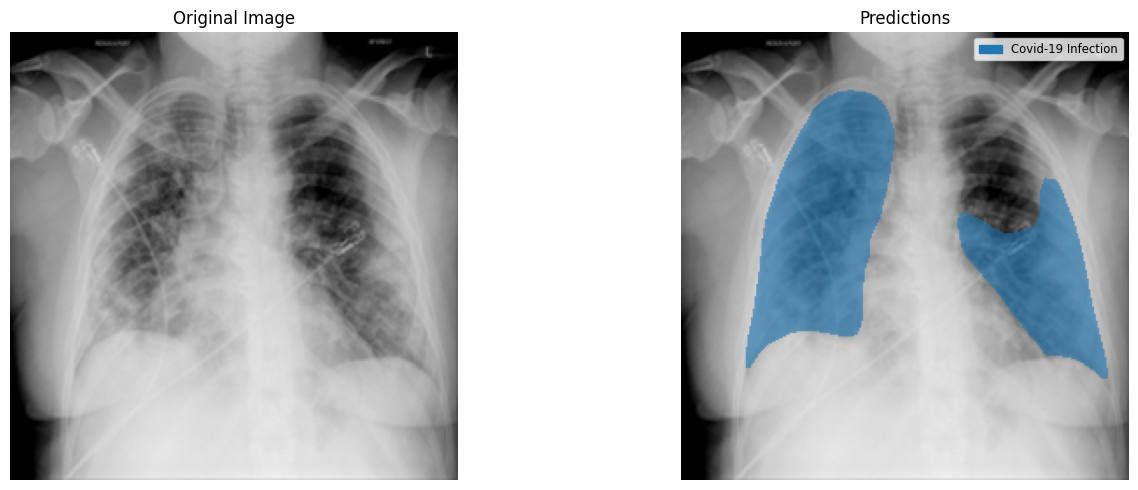

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as mpatches

def overlay_masks(image, masks, colors):
    overlay = image.copy()
    overlay = np.array(overlay, dtype=np.uint8)
    for mask, color in zip(masks, colors):
        overlay[mask > 0] = (overlay[mask > 0] * 0.4 + np.array(color) * 0.6).astype(np.uint8)
    return Image.fromarray(overlay)

def generate_colors(n):
    cmap = plt.get_cmap('tab10')
    colors = [tuple(int(255 * val) for val in cmap(i)[:3]) for i in range(n)]
    return colors

original_image = Image.open('BiomedParse/examples/covid_1585.png').convert('RGB')

colors = generate_colors(len(prompts))

pred_overlay = overlay_masks(original_image, [1*(pred_mask[i] > 0.5) for i in range(len(prompts))], colors)

gt_overlay = overlay_masks(original_image, gt_masks, colors)

legend_patches = [mpatches.Patch(color=np.array(color) / 255, label=prompt) for color, prompt in zip(colors, prompts)]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(pred_overlay)
axes[1].set_title("Predictions")
axes[1].axis('off')
axes[1].legend(handles=legend_patches, loc='upper right', fontsize='small')

# axes[2].imshow(gt_overlay)
# axes[2].set_title("Ground Truth")
# axes[2].axis('off')
# axes[2].legend(handles=legend_patches, loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()



#### this can be used with the nifti and dicom files as well

In [ ]:
# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
pretrained_pth = 'hf_hub:microsoft/BiomedParse'

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

/home/ec2-user/anaconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(che

In [ ]:
import json
import matplotlib.pyplot as plt

from inference_utils.processing_utils import read_nifti


def inference_nifti(file_path, text_prompts, is_CT, slice_idx, site=None, HW_index=(0, 1), channel_idx=None, rotate=0):
    image = read_nifti(file_path, is_CT, slice_idx, site=site,
                       HW_index=HW_index, channel_idx=channel_idx)

    pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)

    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, text_prompts, rotate=rotate)

    return image, pred_mask

In [ ]:
import json
import matplotlib.pyplot as plt

from inference_utils.processing_utils import read_nifti


def inference_nifti(file_path, text_prompts, is_CT, slice_idx, site=None, HW_index=(0, 1), channel_idx=None, rotate=0):
    image = read_nifti(file_path, is_CT, slice_idx, site=site,
                       HW_index=HW_index, channel_idx=channel_idx)

    pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)

    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, text_prompts, rotate=rotate)

    return image, pred_mask

In [ ]:
def plot_segmentation_masks(original_image, segmentation_masks, texts, rotate=0):
    ''' Plot a list of segmentation mask over an image.
    '''
    original_image = original_image[:, :, :3]
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(np.rot90(original_image, rotate), cmap='gray')
    ax[0].set_title('Original Image')
    # grid off
    for a in ax:
        a.axis('off')

    for i, mask in enumerate(segmentation_masks):

        ax[i+1].set_title(texts[i])
        mask_temp = original_image.copy()
        mask_temp[mask > 0.5] = [255, 0, 0]
        mask_temp[mask <= 0.5] = [0, 0, 0, ]
        ax[i+1].imshow(np.rot90(mask_temp, rotate), alpha=0.9)
        ax[i+1].imshow(np.rot90(original_image, rotate), cmap='gray', alpha=0.5)


    plt.show()

In [ ]:
from PIL import Image
import torch
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES

from inference_utils.inference import interactive_infer_image
from inference_utils.output_processing import check_mask_stats

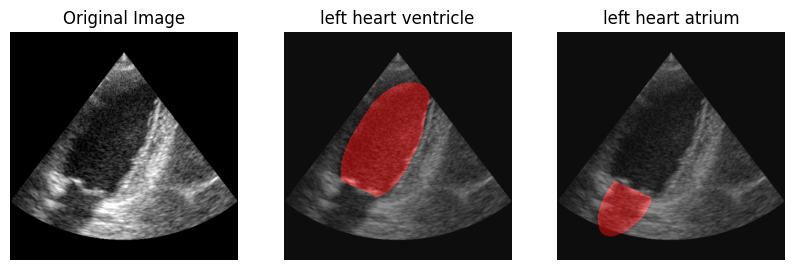

left heart ventricle P-value: 0.38664328259036435
left heart atrium P-value: 0.43737692481273266


In [ ]:
image_path = 'examples/patient0500_2CH_half_sequence.nii.gz'
text_prompt = ['left heart ventricle', 'left heart atrium']
slide_idx = 0

image, pred_mask = inference_nifti(image_path, text_prompt, is_CT=False, slice_idx=slide_idx, site=None, rotate=3)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Ultrasound-Cardiac', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

In [ ]:
import os
import glob

# Method 1: Using glob to search recursively
file_path = glob.glob('**/*CT_kidney.nii.gz', recursive=True)
print(f"Found at: {file_path}")

# Method 2: Using os.walk to search recursively
def find_file(filename):
    for root, dirs, files in os.walk('.'):
        if filename in files:
            return os.path.abspath(os.path.join(root, filename))
    return None

path = find_file('CT_kidney.nii.gz')
print(f"Full path: {path}")

# To get current working directory
print(f"Current directory: {os.getcwd()}")

Found at: ['examples/CT_kidney.nii.gz', 'BiomedParse/examples/CT_kidney.nii.gz']
Full path: /home/ec2-user/SageMaker/BiomedParse/examples/CT_kidney.nii.gz
Current directory: /home/ec2-user/SageMaker/BiomedParse


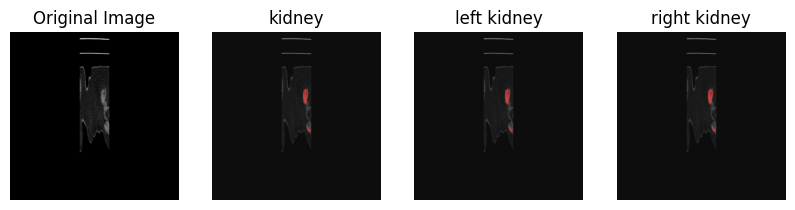

kidney P-value: 6.93608825472601e-05
left kidney P-value: 5.753670266180463e-05
right kidney P-value: 0.0


In [ ]:
image_path = 'BiomedParse/examples/CT_kidney.nii.gz'
text_prompt = ['kidney','left kidney','right kidney']
slide_idx = 68

image, pred_mask =  inference_nifti(image_path, text_prompt, is_CT=True, slice_idx=slide_idx, site='abdomen', rotate=1)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'CT-Abdomen', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')